# Assignment 2

Before working on this assignment please read these instructions fully. In the submission area, you will notice that you can click the link to **Preview the Grading** for each step of the assignment. This is the criteria that will be used for peer grading. Please familiarize yourself with the criteria before beginning the assignment.

An NOAA dataset has been stored in the file `data/C2A2_data/BinnedCsvs_d200/11ad6e1a1108955ee59dd42cf828a867bb400c664615141cbc003137.csv`. The data for this assignment comes from a subset of The National Centers for Environmental Information (NCEI) [Daily Global Historical Climatology Network](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt) (GHCN-Daily). The GHCN-Daily is comprised of daily climate records from thousands of land surface stations across the globe.

Each row in the assignment datafile corresponds to a single observation.

The following variables are provided to you:

* **id** : station identification code
* **date** : date in YYYY-MM-DD format (e.g. 2012-01-24 = January 24, 2012)
* **element** : indicator of element type
    * TMAX : Maximum temperature (tenths of degrees C)
    * TMIN : Minimum temperature (tenths of degrees C)
* **value** : data value for element (tenths of degrees C)

For this assignment, you must:

1. Read the documentation and familiarize yourself with the dataset, then write some python code which returns a line graph of the record high and record low temperatures by day of the year over the period 2005-2014. The area between the record high and record low temperatures for each day should be shaded.
2. Overlay a scatter of the 2015 data for any points (highs and lows) for which the ten year record (2005-2014) record high or record low was broken in 2015.
3. Watch out for leap days (i.e. February 29th), it is reasonable to remove these points from the dataset for the purpose of this visualization.
4. Make the visual nice! Leverage principles from the first module in this course when developing your solution. Consider issues such as legends, labels, and chart junk.

The data you have been given is near **Porto, Porto, Portugal**, and the stations the data comes from are shown on the map below.

In [1]:
import matplotlib.pyplot as plt
import mplleaflet
import numpy as np
import pandas as pd

def leaflet_plot_stations(binsize, hashid):

    df = pd.read_csv('../materials/BinSize_d{}.csv'.format(binsize))

    station_locations_by_hash = df[df['hash'] == hashid]

    lons = station_locations_by_hash['LONGITUDE'].tolist()
    lats = station_locations_by_hash['LATITUDE'].tolist()

    plt.figure(figsize=(8,8))

    plt.scatter(lons, lats, c='r', alpha=0.7, s=200)

    return mplleaflet.display()

leaflet_plot_stations(200,'11ad6e1a1108955ee59dd42cf828a867bb400c664615141cbc003137')

Load data

In [2]:
df = pd.read_csv('../materials/11ad6e1a1108955ee59dd42cf828a867bb400c664615141cbc003137.csv')

In [3]:
df.shape

(22669, 4)

In [4]:
df.head(5)

,ID,Date,Element,Data_Value
0,PO000008575,2015-09-06,TMIN,117
1,PO000008575,2008-10-24,TMAX,183
2,SPE00120368,2007-10-25,TMIN,66
3,PO000008546,2008-01-04,TMAX,109
4,SPE00120368,2015-04-21,TMIN,71


Confirm how many IDs (locations) do we have

In [5]:
df['ID'].value_counts()

SPE00120368    8034
SPE00120413    7907
PO000008575    6325
PO000008546     403
Name: ID, dtype: int64

Filter

In [6]:
df['month_day'] = df.apply(lambda x: x.Date[-5:], axis = 1)

In [7]:
df = df[df['month_day'] != '02-29']

In [8]:
df['Date'] = df.apply(lambda x: pd.to_datetime(x['Date']), axis = 1)

In [9]:
df['Date'].min(), df['Date'].max()

(Timestamp('2005-01-01 00:00:00'), Timestamp('2015-12-31 00:00:00'))

In [10]:
df.head()

,ID,Date,Element,Data_Value,month_day
0,PO000008575,2015-09-06,TMIN,117,09-06
1,PO000008575,2008-10-24,TMAX,183,10-24
2,SPE00120368,2007-10-25,TMIN,66,10-25
3,PO000008546,2008-01-04,TMAX,109,01-04
4,SPE00120368,2015-04-21,TMIN,71,04-21


In [11]:
before_last_year_df = df[df['Date'] < '2015-01-01']

In [12]:
last_year_df = df[df['Date'] >= '2015-01-01']

Compute relevant stats for period between 2005 and 2014 and also for 2015

In [13]:
before_last_year_daily_df = before_last_year_df.groupby('month_day').apply(lambda x: pd.Series({
            'tmin': x.Data_Value.min(),
            'tmax': x.Data_Value.max()
        }))

In [14]:
before_last_year_daily_df.head()

,tmax,tmin
month_day,,
01-01,183,-26
01-02,169,0
01-03,169,-9
01-04,152,-1
01-05,182,-43


In [15]:
last_year_daily_df = last_year_df.groupby('month_day').apply(lambda x: pd.Series({
            'tmin': x.Data_Value.min(),
            'tmax': x.Data_Value.max()
        }))

In [16]:
last_year_daily_df.head()

,tmax,tmin
month_day,,
01-01,148,-38
01-02,122,-32
01-03,154,-27
01-04,145,-13
01-05,137,-8


Join datasources

In [17]:
daily_df = pd.merge(left = before_last_year_daily_df, right = last_year_daily_df, how = 'left',
                    left_index = True, right_index = True,
                    suffixes=('_2005_2014', '_2015'),)\
             .reset_index()

In [18]:
daily_df.head()

,month_day,tmax_2005_2014,tmin_2005_2014,tmax_2015,tmin_2015
0,01-01,183,-26,148,-38
1,01-02,169,0,122,-32
2,01-03,169,-9,154,-27
3,01-04,152,-1,145,-13
4,01-05,182,-43,137,-8


Search for cases where the record was broken

In [19]:
daily_df['tmin_broken'] = daily_df['tmin_2015'] < daily_df['tmin_2005_2014']
daily_df['tmax_broken'] = daily_df['tmax_2015'] > daily_df['tmax_2005_2014']

In [20]:
daily_df.head()

,month_day,tmax_2005_2014,tmin_2005_2014,tmax_2015,tmin_2015,tmin_broken,tmax_broken
0,01-01,183,-26,148,-38,True,False
1,01-02,169,0,122,-32,True,False
2,01-03,169,-9,154,-27,True,False
3,01-04,152,-1,145,-13,True,False
4,01-05,182,-43,137,-8,False,False


Plot

In [21]:
%matplotlib notebook
plt.style.use('ggplot')

In [22]:
daily_df['month_day'] = daily_df.apply(lambda x: pd.to_datetime(x['month_day'], format = '%m-%d'), axis = 1)

<IPython.core.display.Javascript object>


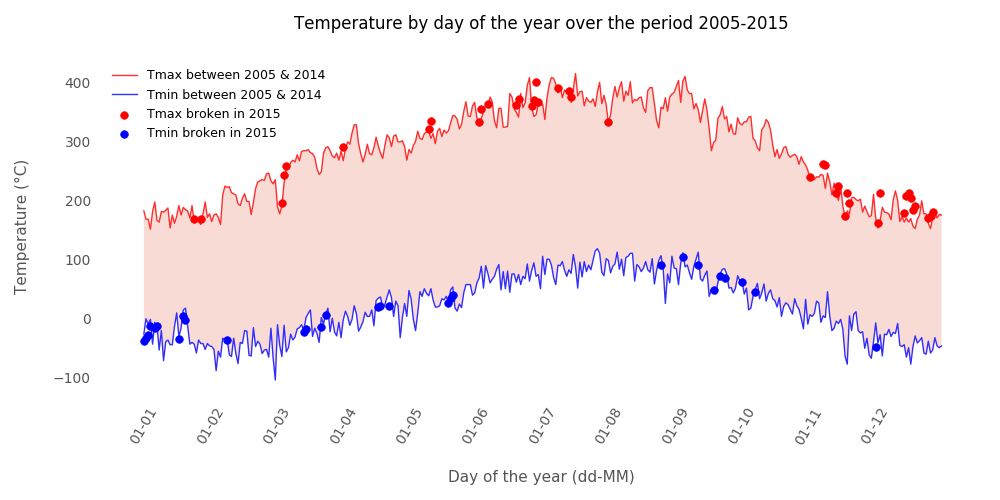

In [23]:
plt.figure(figsize = (10, 5))

#Plot time series
plt.plot(daily_df.tmax_2005_2014.values, marker='', linestyle='-', linewidth = 1,color='r', alpha = 0.8,
         label='Tmax between 2005 & 2014') 

plt.plot(daily_df.tmin_2005_2014.values, marker='', linestyle='-', linewidth = 1,color='b', alpha = 0.8, 
         label='Tmin between 2005 & 2014') 

#Fill aread between the lines
plt.gca().fill_between(range(len(daily_df.tmin_2005_2014.values)), 
                       daily_df.tmin_2005_2014.values, 
                       daily_df.tmax_2005_2014.values, 
                       alpha = 0.2)

#Plot points where the max or min limit was broken
plt.scatter(daily_df[daily_df['tmax_broken'] == True].index.values, 
            daily_df[daily_df['tmax_broken'] == True].tmax_2015.values, 
            s = 30, 
            color = 'r',
            label = 'Tmax broken in 2015')

plt.scatter(daily_df[daily_df['tmin_broken'] == True].index.values, 
            daily_df[daily_df['tmin_broken'] == True].tmin_2015.values, 
            s = 30, 
            color = 'b',
            label = 'Tmin broken in 2015')

#Remove all the ticks and tick labels on Y axis
plt.tick_params (bottom = 'off', top = 'off', left = 'off', right = 'off')

#Remove frame
plt.box(False)

#Add values to xaxis
maximum = max(daily_df.index.values)
minimum = min(daily_df.index.values)
amplitude = maximum - minimum
step = amplitude / 12
xpos = np.arange(minimum, maximum, step)
plt.xticks(xpos, ['01-{:02}'.format(number) for number in np.arange(1, 13)], rotation=60)

#Add labels to the axes
plt.ylabel ('Temperature (°C)\n', size = 11)
plt.xlabel ('\nDay of the year (dd-MM)', size = 11)
plt.title ('Temperature by day of the year over the period 2005-2015\n', fontsize = 12)

#Setup legend
legend = plt.legend(loc = 'upper left', prop={'size': 9})
legend.get_frame().set_color('w')
plt.tight_layout()
plt.show()